## Historical Forest Mapping by DeepLabv3

Do inference and display the semantic segmentation results

__Step 1.__ Import necessary packages

Import all packages, including the local one

In [1]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# local import
from unet import unet_model

__Step 2.__ Find the hardware

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

__Step 3.__ Define file paths needed in this notebook

In [6]:
# define the path to the weights file
weights_dir = "../weights/model.pth"
# path to the test images
img_path = "../demo_image/image.tif"
# path to the test labels
label_path = "../demo_image/target.tif"

__Step 4.__ Initialize the model with trained weights, and set the model in evaluation mode

In [7]:
# import our trained model
model = unet_model.UNet(n_channels=3, n_classes=3)
state_dict = torch.load(weights_dir, map_location=device)
model = model.to(device)
model.load_state_dict(state_dict)

# set the model in evaluation mode
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

__Step 5.__ Input one image in the test set, do the transform required by the model

In [8]:
# load the image
image = Image.open(img_path)

# define the transforms
image_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# apply transforms
image_tr = image_transforms(image)

__Step 6.__ Do the inference, generate the prediction

In [9]:
# do the inference
image_tr = image_tr.to(device)
image_tr = image_tr.unsqueeze(0)

outputs = model(image_tr)

# select the prediction only in the first two classes
outputs = outputs[:, :2, :, :]
# get the prediction
_, preds = torch.max(outputs, 1)

__Step 7.__ Resize the prediction back to the original size, display the image, prediction and ground truth

In [10]:
# load the label
label = Image.open(label_path)

# resize the prediction to the label size
preds = transforms.Resize(size=(label.size[1], label.size[0]), interpolation=transforms.InterpolationMode.NEAREST)(preds)

# convert the prediction and label to numpy array
preds = preds.cpu().numpy()
preds = preds.squeeze(0)
label = np.array(label)
# change color of the prediction and label
colors = {
    0: [0,0,0],  # non-forest is black
    1: [0,255,0],  # forest is green
    2: [128,128,128],    # no-label is gray
    255: [128,128,128]
}
#img = np.array(img)
h, w = label.shape
pred_rgb = np.zeros((h, w, 3), dtype=np.uint8)
label_rgb = np.zeros((h, w, 3), dtype=np.uint8)

for index, rgb in colors.items():
  pred_rgb[preds == index, :] = rgb
  label_rgb[label == index, :] = rgb

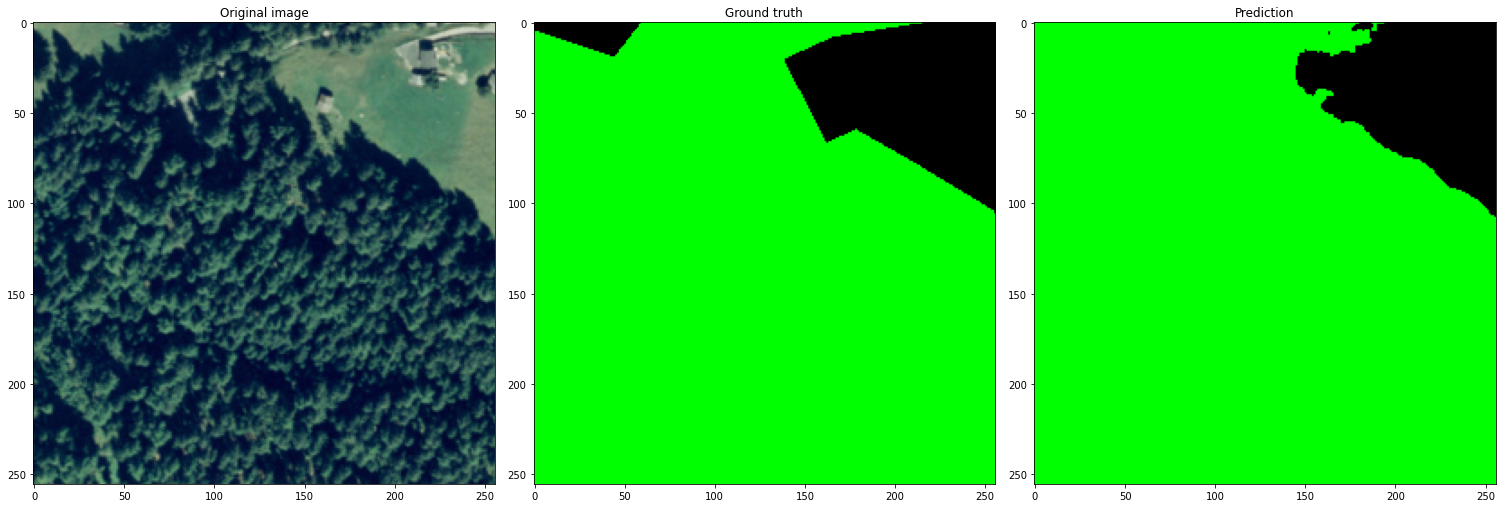

(None, None)

In [11]:
# display the original image, prediction and label
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1), plt.imshow(image), plt.title("Original image")
plt.subplot(1, 3, 2), plt.imshow(label_rgb), plt.title("Ground truth")
plt.subplot(1, 3, 3), plt.imshow(pred_rgb), plt.title("Prediction")
plt.tight_layout(), plt.show()